In [43]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import optuna
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

import numpy as np

data = pd.read_csv('../Data/serenlens_with_features_cleaned_filtered.csv', dtype={'item_id': str}, sep=";")
all_item_ids = data['item_id'].unique()

train_data = pd.read_csv('../train_data.csv', dtype={'item_id': str}, sep=';')
test_data = pd.read_csv('../test_data.csv', dtype={'item_id': str}, sep=';')

def load_embeddings(embedding_path, item_ids):
    embeddings = np.load(embedding_path)
    return {item_id: normalize(embedding.reshape(1, -1)).flatten() for item_id, embedding in zip(item_ids, embeddings)}


train_user_ids = train_data['user_id'].unique()
train_item_ids = train_data['item_id'].unique()
train_user_id_map = {user_id: idx for idx, user_id in enumerate(train_user_ids)}
train_item_id_map = {item_id: idx for idx, item_id in enumerate(train_item_ids)}

interaction_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
svd = TruncatedSVD(n_components=50, random_state=42)
user_embeddings = svd.fit_transform(interaction_matrix)
item_embeddings_mf = svd.components_.T

scaler = StandardScaler()
user_embeddings = scaler.fit_transform(user_embeddings)
item_embeddings_mf = scaler.fit_transform(item_embeddings_mf)

# description embeddings
item_embeddings_dict = load_embeddings('../embeddings/distilroberta_embeddings.npy', all_item_ids)

# default embedding for missing embeddings in test
default_user_embedding = np.mean(user_embeddings, axis=0)
default_item_embedding_svd = np.mean(item_embeddings_mf, axis=0)

default_user_embedding = normalize(default_user_embedding.reshape(1, -1)).flatten() 
default_item_embedding_svd = normalize(default_item_embedding_svd.reshape(1, -1)).flatten()  

train_data_samples = []
sample_weights = []

for idx, row in train_data.iterrows():
    user_idx = train_user_id_map.get(row['user_id'])
    item_idx = train_item_id_map.get(row['item_id'])
    user_embedding = normalize(user_embeddings[user_idx].reshape(1, -1)).flatten() if user_idx is not None else default_user_embedding
    item_embedding = normalize(item_embeddings_mf[item_idx].reshape(1, -1)).flatten() if item_idx is not None else default_item_embedding_svd
    item_embedding_bert = item_embeddings_dict[row['item_id']]
    item_final = np.hstack((item_embedding_bert, item_embedding))
    combined_embedding = np.hstack((user_embedding, item_final))
    train_data_samples.append((combined_embedding, row['serendipity']))



X_train, y_train = zip(*train_data_samples)
X_train = np.array(X_train)
y_train = np.array(y_train)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)


test_data_samples = []
for idx, row in test_data.iterrows():
    user_idx = train_user_id_map.get(row['user_id'])
    item_idx = train_item_id_map.get(row['item_id'])
    user_embedding = normalize(user_embeddings[user_idx].reshape(1, -1)).flatten() if user_idx is not None else default_user_embedding
    item_embedding = normalize(item_embeddings_mf[item_idx].reshape(1, -1)).flatten() if item_idx is not None else default_item_embedding_svd
    item_embedding_bert = item_embeddings_dict[row['item_id']]
    item_final = np.hstack((item_embedding_bert, item_embedding))
    combined_embedding = np.hstack((user_embedding, item_final))
    test_data_samples.append((combined_embedding, row['serendipity']))

X_test, y_test = zip(*test_data_samples)
X_test = np.array(X_test)
y_test = np.array(y_test)


X_train = X_resampled.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_resampled.astype(np.float32)
y_test = y_test.astype(np.float32)
scale_pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

#optuna function
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        #'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 10),
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 10),
        'scale_pos_weight': scale_pos_weight
    }
    
    xgb_model = xgb.XGBClassifier(**param)
    
    X_train_opt, X_valid_opt, y_train_opt, y_valid_opt = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    xgb_model.fit(X_train_opt, y_train_opt, eval_set=[(X_valid_opt, y_valid_opt)], verbose=False)
    
    y_pred = xgb_model.predict(X_valid_opt)
    
    precision = precision_score(y_valid_opt, y_pred)
    recall = recall_score(y_valid_opt, y_pred)
    
    # chose metric to maximaze, F1-score
    return 2 * (precision * recall) / (precision + recall + 1e-10)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("best hyperparameters found:")
print(study.best_params)

# use best hyperparameters
best_params = study.best_params
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Test accuracy: {accuracy}')
print(f'Test precision: {precision}')
print(f'Test recall: {recall}')

[I 2024-09-21 17:30:13,345] A new study created in memory with name: no-name-c011d43a-2b54-4cbf-9d49-0b0c9f426f03
C:\Users\alunoDEI\AppData\Local\Temp\ipykernel_9372\2953543249.py:106: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\alunoDEI\AppData\Local\Temp\ipykernel_9372\2953543249.py:107: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\alunoDEI\AppData\Local\Temp\ipykernel_9372\2953543249.py:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

best hyperparameters found:
{'n_estimators': 434, 'max_depth': 13, 'learning_rate': 0.0512144268043314, 'subsample': 0.8011598490883438, 'colsample_bytree': 0.6462273780072652}
[0]	validation_0-logloss:0.69643
[1]	validation_0-logloss:0.69569
[2]	validation_0-logloss:0.69149
[3]	validation_0-logloss:0.69194
[4]	validation_0-logloss:0.68992
[5]	validation_0-logloss:0.68944
[6]	validation_0-logloss:0.68698
[7]	validation_0-logloss:0.68534
[8]	validation_0-logloss:0.68870
[9]	validation_0-logloss:0.69096
[10]	validation_0-logloss:0.68991
[11]	validation_0-logloss:0.68696
[12]	validation_0-logloss:0.68573
[13]	validation_0-logloss:0.68555
[14]	validation_0-logloss:0.68281
[15]	validation_0-logloss:0.68247
[16]	validation_0-logloss:0.68111
[17]	validation_0-logloss:0.67821
[18]	validation_0-logloss:0.67630
[19]	validation_0-logloss:0.67725
[20]	validation_0-logloss:0.68027
[21]	validation_0-logloss:0.68096
[22]	validation_0-logloss:0.68383
[23]	validation_0-logloss:0.68324
[24]	validation_0

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1395  902]
 [  35   64]]
              precision    recall  f1-score   support

         0.0       0.98      0.61      0.75      2297
         1.0       0.07      0.65      0.12        99

    accuracy                           0.61      2396
   macro avg       0.52      0.63      0.43      2396
weighted avg       0.94      0.61      0.72      2396



In [45]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  #positive class probability

# experiment different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"better thresholds for F1-score: {best_threshold}")

better thresholds for F1-score: 0.8832913041114807


In [46]:
y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)

In [47]:
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))

[[2122  175]
 [  74   25]]
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      2297
         1.0       0.12      0.25      0.17        99

    accuracy                           0.90      2396
   macro avg       0.55      0.59      0.56      2396
weighted avg       0.93      0.90      0.91      2396



In [48]:
xgb_model.save_model('serendipity_classifier_distilroberta.json')

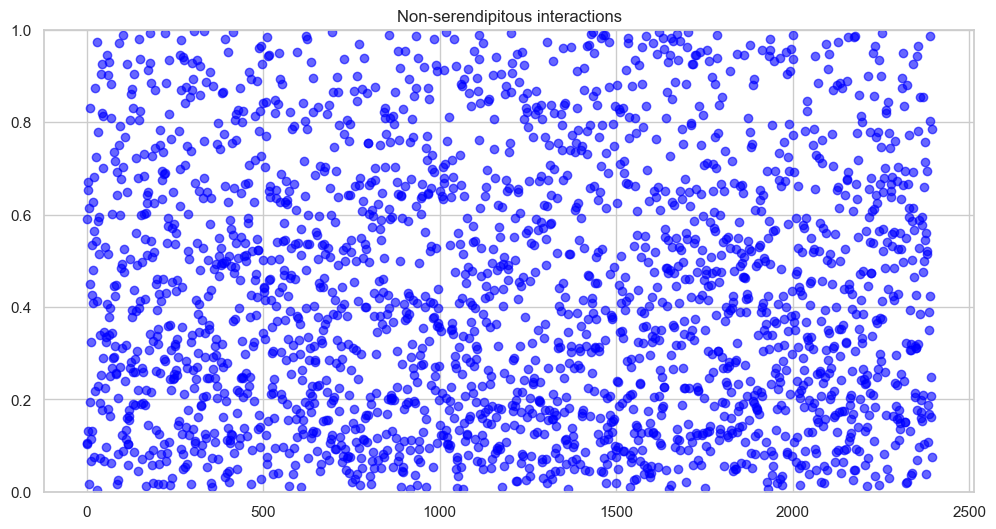

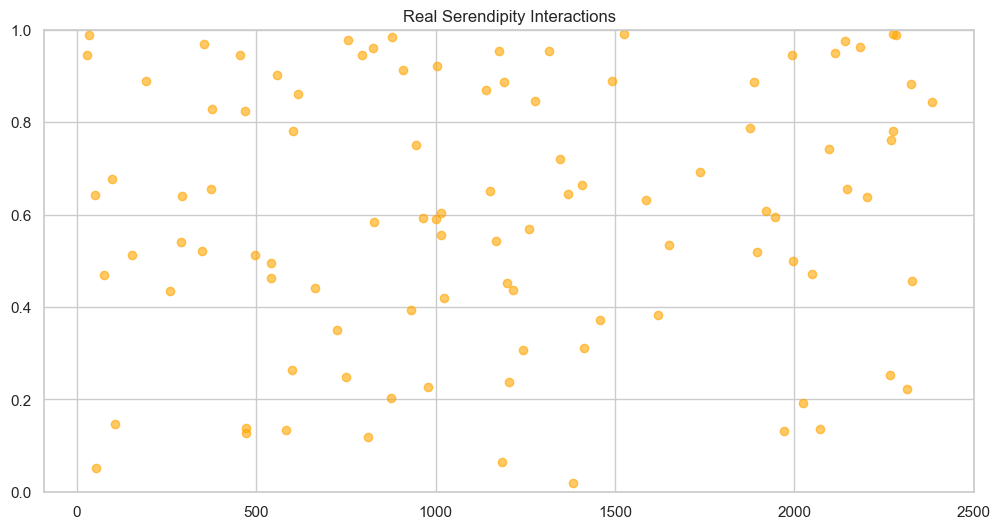

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Item Index': np.arange(len(y_test_array)),
    'Actual Serendipity': y_test_array,
    'Predicted Probability': y_pred_prob_array
})

df_class_0 = df[df['Actual Serendipity'] == 0]
df_class_1 = df[df['Actual Serendipity'] == 1]

plt.figure(figsize=(12, 6))
plt.scatter(df_class_0['Item Index'], df_class_0['Predicted Probability'], color='blue', alpha=0.6)
plt.title('Non-serendipitous interactions')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df_class_1['Item Index'], df_class_1['Predicted Probability'], color='orange', alpha=0.6)
plt.title('Real Serendipity Interactions')
plt.ylim(0, 1)
plt.show()